# Rezonans falowy w prostokątnej zatoce – równania płytkiej wody 2D

W projekcie badamy sejszę (długookresowe drgania poziomu wody) w prostokątnej,
zamkniętej zatoce, modelowanej liniowymi równaniami płytkiej wody w 2D.


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import PyMPDATA
from open_atmos_jupyter_utils import show_plot, show_anim


## Układ fizyczny i pytanie badawcze

Rozważamy prostokątną, zamkniętą zatokę o **stałej** głębokości \(H_0\)

Swobodne drgania (sejsze) opisujemy liniowymi równaniami płytkiej wody
dla odchylenia poziomu wody \(\eta(x,y,t)\) oraz prędkości \(u(x,y,t)\),
\(v(x,y,t)\).

**Pytanie badawcze**

Jak zmienia się maksymalna wysokość fali przy brzegu zatoki oraz okres oscylacji
w wybranym punkcie przy brzegu przy zmianie rozdzielczości siatki i kroku
czasowego (czyli jak wygląda zbieżność rozwiązania)?

In [42]:
g = 9.81
H0 = 20.0
Lx = 2000.0
Ly = 500.0

nx_base = 80
ny_base = 20
T_end = 600.0

c = np.sqrt(g * H0)
dx_base = Lx / nx_base
dy_base = Ly / ny_base
cfl = 0.5
dt_base = cfl * min(dx_base, dy_base) / c

print(f"dx={dx_base:.1f} m, dy={dy_base:.1f} m, dt≈{dt_base:.2f} s, c≈{c:.2f} m/s")


dx=25.0 m, dy=25.0 m, dt≈0.89 s, c≈14.01 m/s


## Warunek początkowy i siatka

Siatka jest prostokątna i równomierna:

- w kierunku x: `nx` węzłów na odcinku \([0, L_x]\),
- w kierunku y: `ny` węzłów na odcinku \([0, L_y]\).

Aby wzbudzić sejszę, początkowo unosimy poziom wody z profilem
sinusowym wzdłuż osi zatoki (fala stojąca), jednorodnym w y.
Początkowe prędkości ustawiamy na zero.


In [43]:
def make_grid(nx, ny, Lx=Lx, Ly=Ly):
    x = np.linspace(0.0, Lx, nx)
    y = np.linspace(0.0, Ly, ny)
    X, Y = np.meshgrid(x, y, indexing="ij")
    return x, y, X, Y

def initial_condition(nx, ny, amp=0.2):
    """
    Zwraca eta, u, v na siatce nx x ny.
    amp – amplituda początkowego zaburzenia [m].
    """
    x, y, X, Y = make_grid(nx, ny, Lx=Lx, Ly=Ly)

    eta0 = amp * np.cos(np.pi * X / Lx)
    u0 = np.zeros_like(eta0)
    v0 = np.zeros_like(eta0)
    return (x, y, X, Y), (eta0, u0, v0)

(x_test, y_test, X_test, Y_test), (eta0_test, u0_test, v0_test) = initial_condition(nx_base, ny_base)
print(eta0_test.shape, u0_test.shape, v0_test.shape)


(80, 20) (80, 20) (80, 20)


## Równania płytkiej wody i schemat numeryczny

Używamy liniowych równań płytkiej wody (stała głębokość \(H_0\)):

\[
\partial_t \eta + H_0(\partial_x u + \partial_y v) = 0,
\]
\[
\partial_t u + g\,\partial_x \eta = 0,\qquad
\partial_t v + g\,\partial_y \eta = 0.
\]

Dyskretyzacja:

- siatka równomierna,
- różnice centralne w przestrzeni,
- Euler w przód w czasie,
- brzeg zatoki jest „sztywny”: komponent normalny prędkości = 0
  (u=0 na lewym/prawym brzegu, v=0 na górnym/dolnym).


In [44]:
def apply_boundary_conditions(eta, u, v):

    u[0, :] = 0.0
    u[-1, :] = 0.0

    v[:, 0] = 0.0
    v[:, -1] = 0.0

    eta[0, :] = eta[1, :]
    eta[-1, :] = eta[-2, :]
    eta[:, 0] = eta[:, 1]
    eta[:, -1] = eta[:, -2]

def shallow_water_step(eta, u, v, dx, dy, dt, g=g, H0=H0):
    """
    Jeden krok czasowy liniowych równań płytkiej wody.
    """
    apply_boundary_conditions(eta, u, v)

    d_eta_dx = (eta[2:, 1:-1] - eta[:-2, 1:-1]) / (2.0 * dx)
    d_eta_dy = (eta[1:-1, 2:] - eta[1:-1, :-2]) / (2.0 * dy)

    div_u = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2.0 * dx)
    div_v = (v[1:-1, 2:] - v[1:-1, :-2]) / (2.0 * dy)
    div_uv = div_u + div_v

    eta_new = eta.copy()
    u_new = u.copy()
    v_new = v.copy()

    eta_new[1:-1, 1:-1] = eta[1:-1, 1:-1] - dt * H0 * div_uv

    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * g * d_eta_dx
    v_new[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * g * d_eta_dy

    apply_boundary_conditions(eta_new, u_new, v_new)
    return eta_new, u_new, v_new


## Funkcja uruchamiająca symulację

Funkcja `run_shallow_water`:

- dobiera krok czasowy z warunku CFL,
- integruje równania do chwili `T`,
- zapisuje przebieg \(\eta(t)\) w punkcie przy brzegu,
- zapisuje migawki pól \(\eta, u, v\) (potrzebne do wizualizacji i animacji),
- liczy średnią energię jako prosty wskaźnik stabilności.


In [45]:
def run_shallow_water(nx, ny, T=T_end, store_every=20, amp=0.2):
    x, y, X, Y = make_grid(nx, ny, Lx=Lx, Ly=Ly)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    c = np.sqrt(g * H0)
    dt = cfl * min(dx, dy) / c
    n_steps = int(T / dt)

    (_, _, _, _), (eta, u, v) = initial_condition(nx, ny, amp=amp)

    gauge_i = nx - 1
    gauge_j = ny // 2

    times = []
    gauge_eta = []
    energy = []
    snapshots_eta = []
    snapshots_u = []
    snapshots_v = []

    for n in range(n_steps + 1):
        t = n * dt
        if n % store_every == 0:
            times.append(t)
            gauge_eta.append(eta[gauge_i, gauge_j])
            E = 0.5 * H0 * (u**2 + v**2) + 0.5 * g * eta**2
            energy.append(E.mean())
            snapshots_eta.append(eta.copy())
            snapshots_u.append(u.copy())
            snapshots_v.append(v.copy())

        eta, u, v = shallow_water_step(eta, u, v, dx, dy, dt)

    return {
        "x": x, "y": y, "X": X, "Y": Y,
        "times": np.array(times),
        "gauge_eta": np.array(gauge_eta),
        "energy": np.array(energy),
        "snapshots_eta": np.array(snapshots_eta),
        "snapshots_u": np.array(snapshots_u),
        "snapshots_v": np.array(snapshots_v),
        "dt": dt,
        "dx": dx,
        "dy": dy,
        "n_steps": n_steps,
    }

result_base = run_shallow_water(nx_base, ny_base, T=0.2*T_end, store_every=5)


## Wizualizacja: powierzchnia cieczy i przekroje

Wygenerujemy:

- mapę pola \(\eta(x,y)\) (2D),
- przekrój wzdłuż osi zatoki (stałe y).


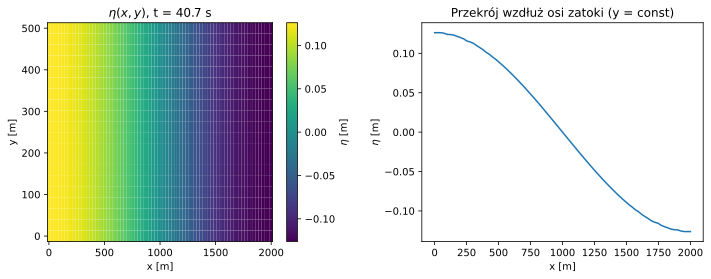

In [46]:
def plot_eta_snapshot(res, frame_idx=0, filename=None):
    X = res["X"]
    Y = res["Y"]
    eta = res["snapshots_eta"][frame_idx]
    t = res["times"][frame_idx]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im = axes[0].pcolormesh(X, Y, eta, shading="auto")
    axes[0].set_title(f"$\\eta(x,y)$, t = {t:.1f} s")
    axes[0].set_xlabel("x [m]")
    axes[0].set_ylabel("y [m]")
    fig.colorbar(im, ax=axes[0], label="$\\eta$ [m]")

    j_mid = eta.shape[1] // 2
    axes[1].plot(res["x"], eta[:, j_mid])
    axes[1].set_title("Przekrój wzdłuż osi zatoki (y = const)")
    axes[1].set_xlabel("x [m]")
    axes[1].set_ylabel("$\\eta$ [m]")

    fig.tight_layout()
    show_plot(filename or "eta_snapshot", fig=fig)

plot_eta_snapshot(
    result_base,
    frame_idx=len(result_base["snapshots_eta"]) // 3,
    filename="eta_snapshot_base",
)


### Wektorowe pole prędkości

Poniżej wykres wektorowy pola prędkości \((u,v)\) w wybranego momencie.


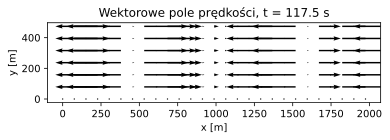

In [47]:
def velocity_field_snapshot(res, frame_idx=0, filename=None):
    X = res["X"]
    Y = res["Y"]
    u = res["snapshots_u"][frame_idx]
    v = res["snapshots_v"][frame_idx]
    t = res["times"][frame_idx]

    skip = max(1, X.shape[0] // 25)
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.quiver(X[::skip, ::skip], Y[::skip, ::skip],
              u[::skip, ::skip], v[::skip, ::skip])
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(f"Wektorowe pole prędkości, t = {t:.1f} s")
    ax.set_aspect("equal")
    show_plot(filename or "velocity_field", fig=fig)

velocity_field_snapshot(result_base, frame_idx=-1, filename="velocity_field_base")



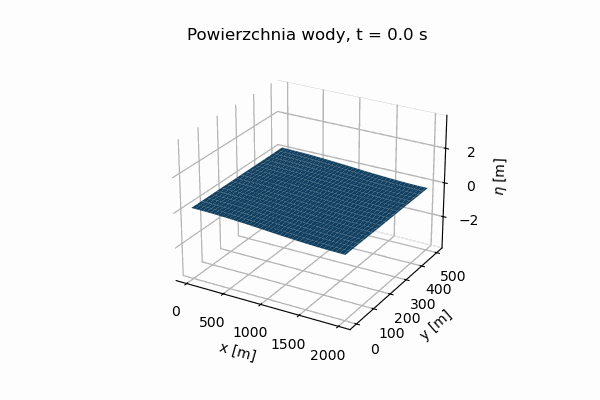

HTML(value="<a href='.\\tmpsp_6e8io.gif' target='_blank'>.\\tmpsp_6e8io.gif</a><br>")

In [48]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

def make_3d_surface_frame(frame_idx, res, smooth_sigma=1.0):
    X = res["X"]
    Y = res["Y"]
    eta_raw = res["snapshots_eta"][frame_idx]
    t = res["times"][frame_idx]

    eta = gaussian_filter(eta_raw, sigma=smooth_sigma)

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(
        X, Y, eta,
        linewidth=0,
        antialiased=True
    )

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("$\\eta$ [m]")
    ax.set_title(f"Powierzchnia wody, t = {t:.1f} s")

    zmax = np.max(np.abs(res["snapshots_eta"]))
    ax.set_zlim(-zmax, zmax)

    ax.view_init(elev=25, azim=-60)

    return fig

frame_range = range(len(result_base["snapshots_eta"]))

show_anim(
    lambda k: make_3d_surface_frame(k, result_base),
    frame_range=frame_range,
)


## Analiza zbieżności przy podwojeniu rozdzielczości

Sprawdzamy wpływ rozdzielczości przestrzennej i czasowej na wynik:

- siatka bazowa: \((nx_{\text{base}}, ny_{\text{base}})\),
- siatka gęsta: \((2\,nx_{\text{base}}, 2\,ny_{\text{base}})\),
- krok czasowy dobierany z tego samego warunku CFL,
- porównujemy przebieg \(\eta(t)\) w punkcie pomiarowym przy brzegu.

Dla oceny zbieżności liczymy błąd L2 między przebiegami (po interpolacji
dokładniejszego rozwiązania na chwile z siatki grubszej).


Błąd L2 (gauge_eta): 2.9407e+52 m, względny: 17.18%


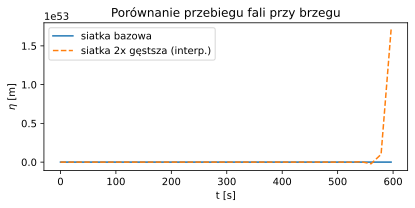

In [49]:
from scipy.interpolate import interp1d

result_coarse = run_shallow_water(nx_base, ny_base, T=T_end, store_every=20)
result_fine = run_shallow_water(2*nx_base, 2*ny_base, T=T_end, store_every=40)

t_coarse = result_coarse["times"]
eta_coarse = result_coarse["gauge_eta"]

f_eta_fine = interp1d(
    result_fine["times"],
    result_fine["gauge_eta"],
    kind="cubic",
    fill_value="extrapolate",
)
eta_fine_interp = f_eta_fine(t_coarse)

error_l2 = np.sqrt(np.mean((eta_fine_interp - eta_coarse)**2))
rel_error = error_l2 / np.max(np.abs(eta_fine_interp))

print(f"Błąd L2 (gauge_eta): {error_l2:.4e} m, względny: {rel_error:.2%}")

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(t_coarse, eta_coarse, label="siatka bazowa")
ax.plot(t_coarse, eta_fine_interp, "--", label="siatka 2x gęstsza (interp.)")
ax.set_xlabel("t [s]")
ax.set_ylabel("$\\eta$ [m]")
ax.set_title("Porównanie przebiegu fali przy brzegu")
ax.legend()
fig.tight_layout()
show_plot("convergence_gauge_eta", fig=fig)


## Demo: użycie PyMPDATA (adwekcja plamy 2D)

Poniżej minimalny przykład adwekcji gaussowskiej plamy w stałym polu
prędkości.


In [50]:
from numba import set_num_threads
set_num_threads(1)

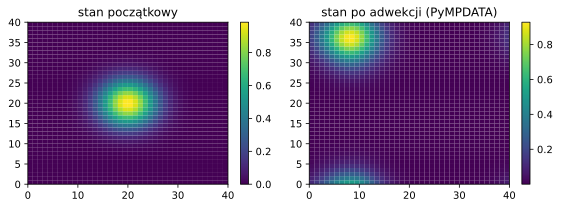

In [51]:
from PyMPDATA import Options, ScalarField, VectorField, Stepper, Solver
from PyMPDATA.boundary_conditions import Periodic

def run_pympdata_demo():
    opts = Options(n_iters=2)
    nx, ny = 40, 40
    halo = opts.n_halo

    Cx, Cy = -0.3, -0.15

    xi, yi = np.indices((nx, ny), dtype=float)
    sigma_x = nx / 10.0
    sigma_y = ny / 10.0

    gaussian = np.exp(
        -((xi + 0.5 - nx/2.0)**2) / (2.0 * sigma_x**2)
        -((yi + 0.5 - ny/2.0)**2) / (2.0 * sigma_y**2)
    )

    advectee = ScalarField(
        data=gaussian,
        halo=halo,
        boundary_conditions=(Periodic(), Periodic()),
    )

    advector = VectorField(
        data=(
            np.full((nx + 1, ny), Cx),
            np.full((nx, ny + 1), Cy),
        ),
        halo=halo,
        boundary_conditions=(Periodic(), Periodic()),
    )

    stepper = Stepper(options=opts, grid=(nx, ny))
    solver = Solver(stepper=stepper, advectee=advectee, advector=advector)
    solver.advance(n_steps=80)
    final_state = solver.advectee.get()

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    im0 = axes[0].pcolormesh(gaussian, shading="auto")
    axes[0].set_title("stan początkowy")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].pcolormesh(final_state, shading="auto")
    axes[1].set_title("stan po adwekcji (PyMPDATA)")
    fig.colorbar(im1, ax=axes[1])

    fig.tight_layout()
    show_plot("pympdata_demo", fig=fig)

run_pympdata_demo()